In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from scipy.optimize import curve_fit

import emcee
import corner

from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
X = np.load('../solutions/noisydetector.npy')
print(X.shape)
print(X)

(2000, 3)
[[ 1.64846254  0.77179892  1.81395692]
 [ 1.39509665  0.5330968   1.42738704]
 [ 2.90309446  1.41468844  2.29865643]
 ...
 [ 9.55032295  3.12512086  5.75843618]
 [11.01366437  3.77033436  6.23327213]
 [ 1.66638559  0.80869969  1.522431  ]]


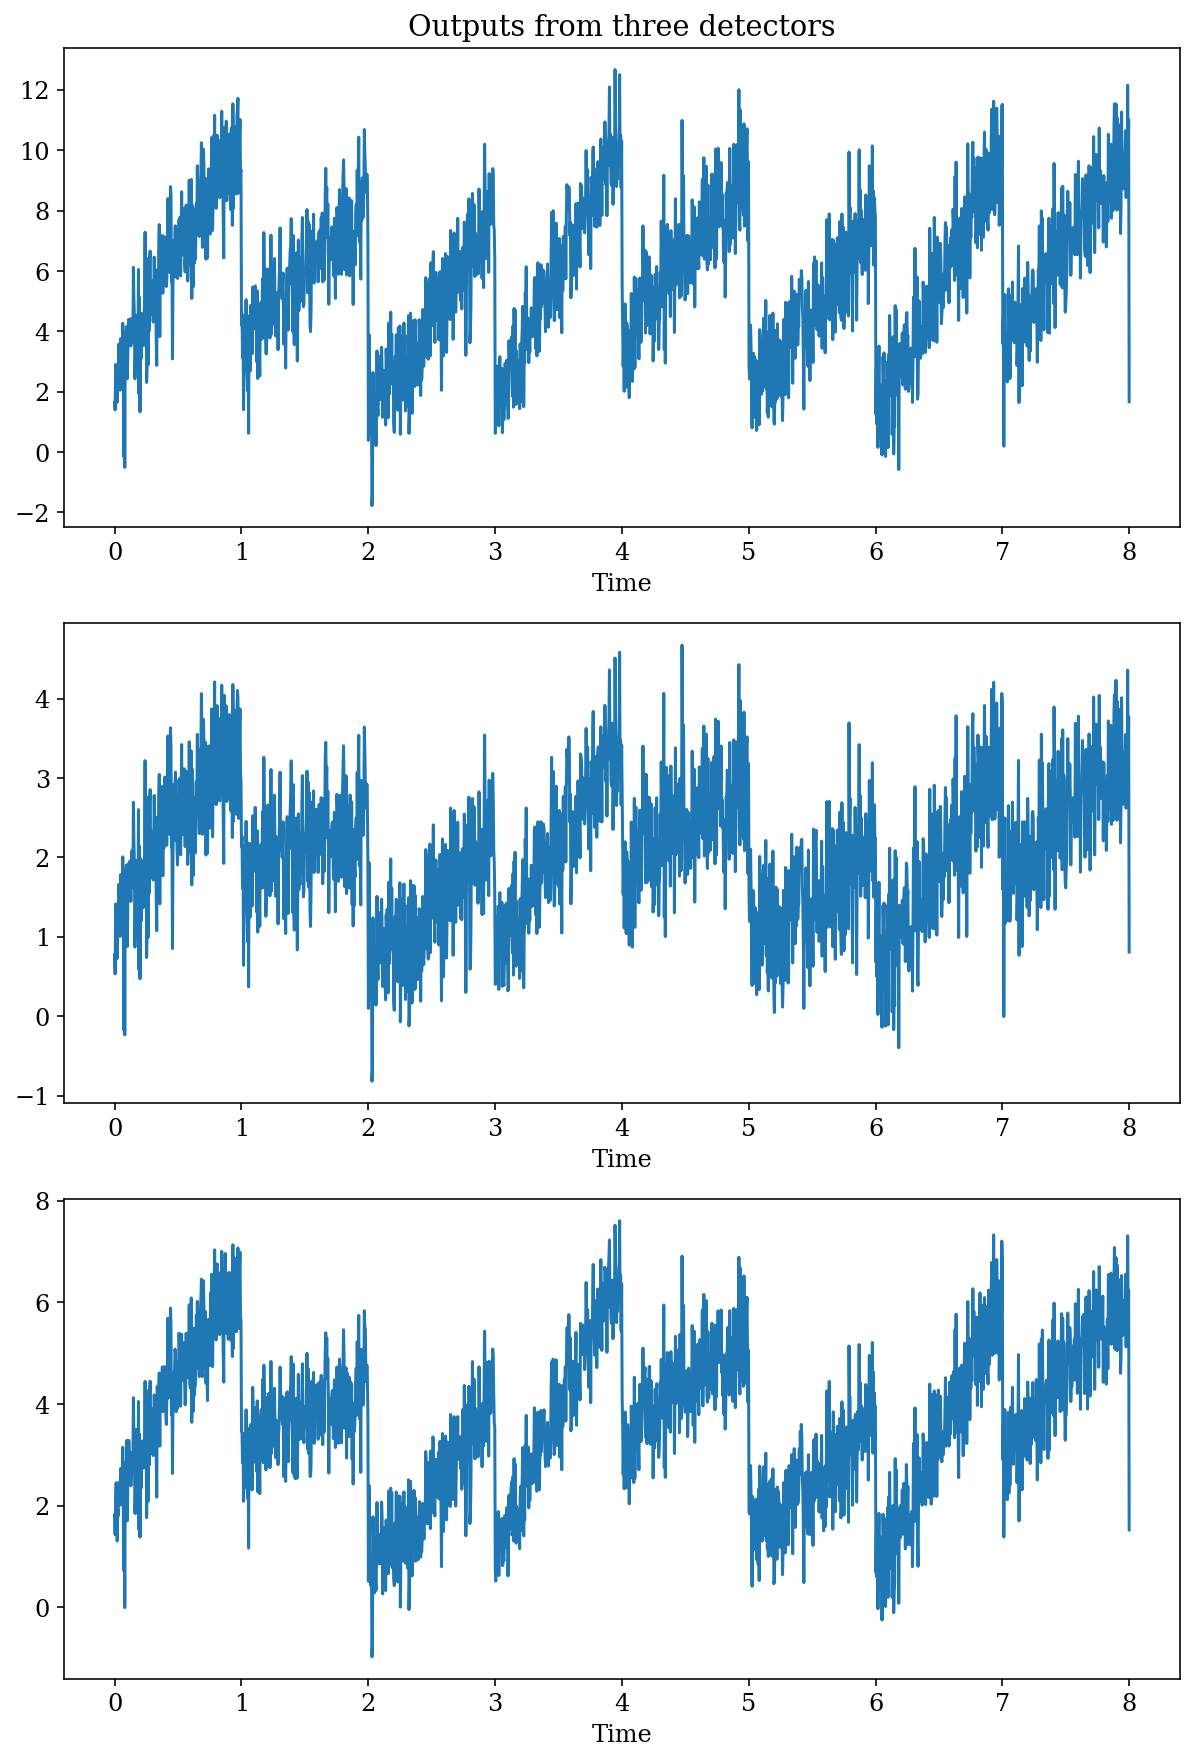

In [3]:
time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');

we're observing a cepheid star $\implies$ smooth variability $\implies$ sinusoidal behaviour?  
Try to reconstruct it:

## PCA

In [4]:
pca = PCA(n_components = 3)
pca_fit = pca.fit_transform(X)

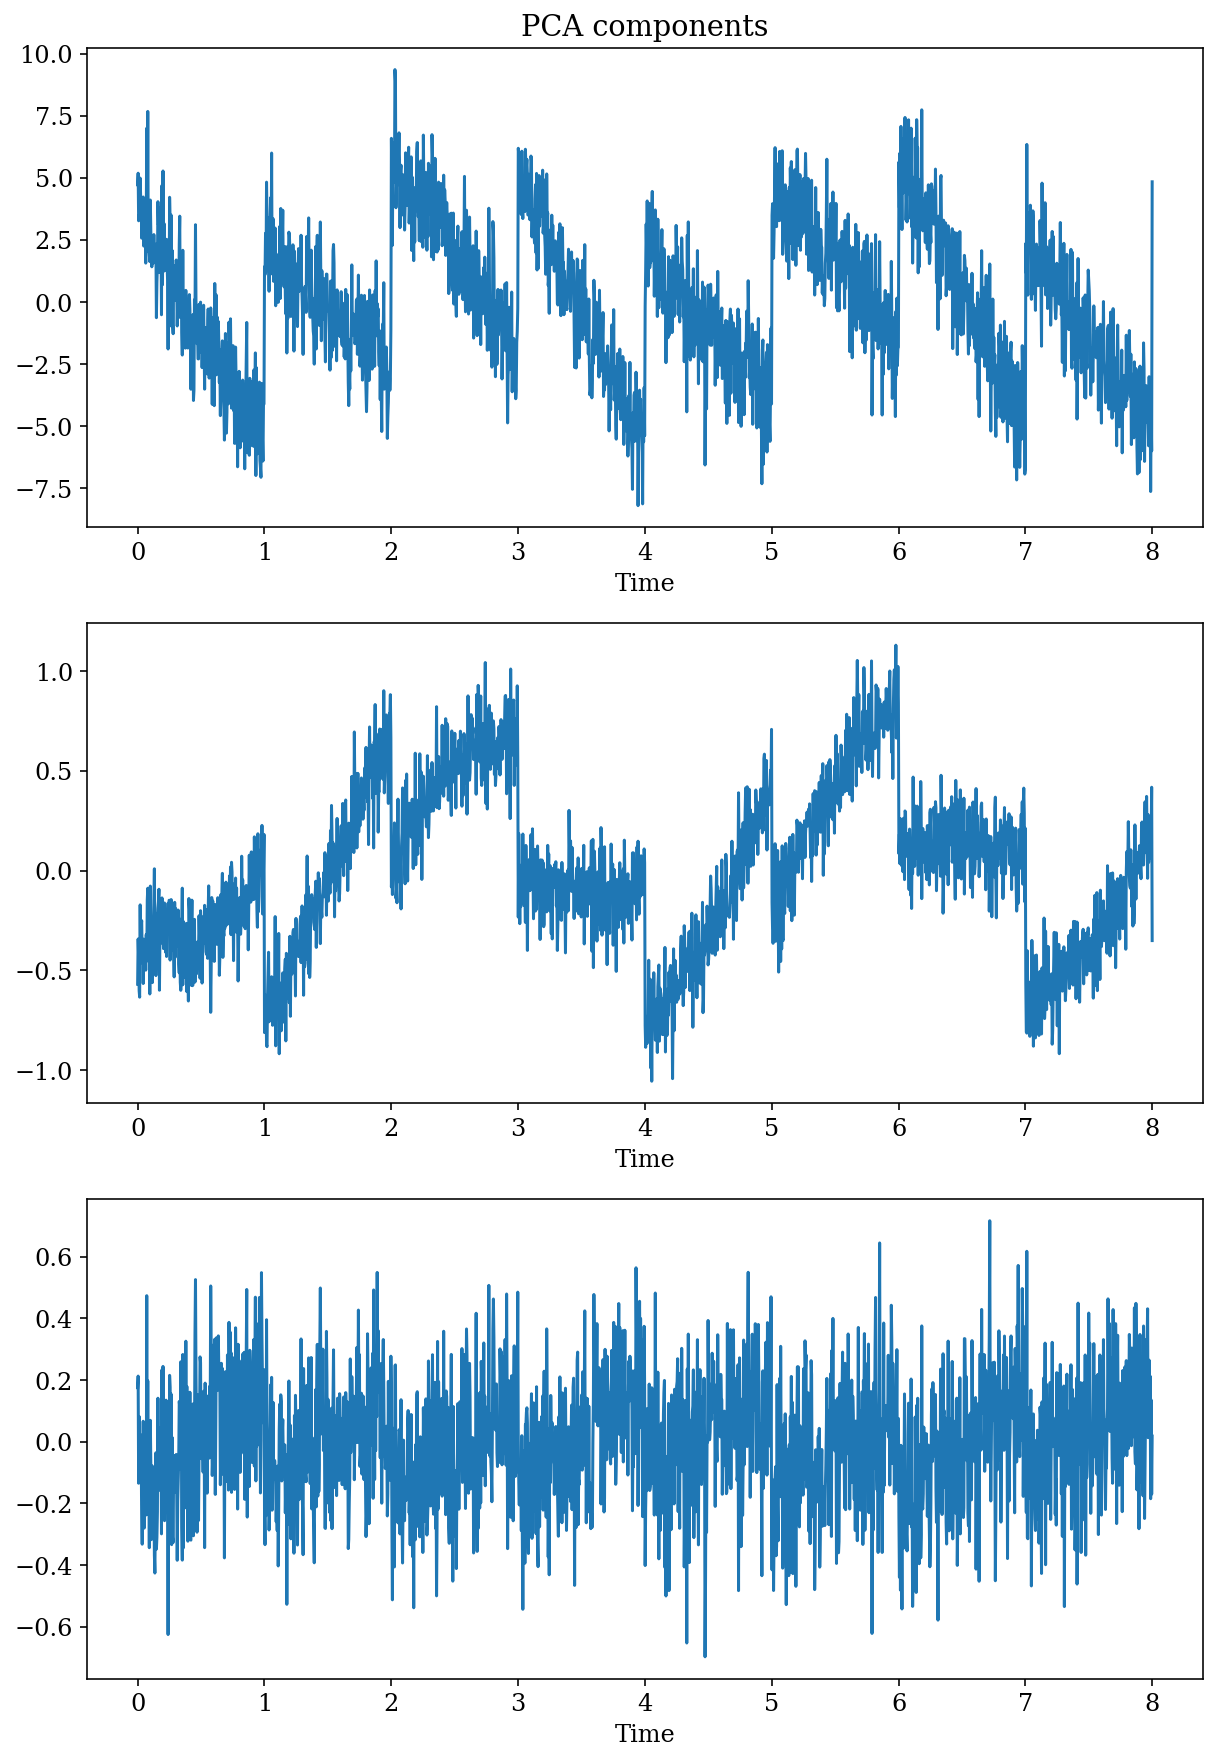

In [5]:
fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs, pca_fit.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('PCA components');

still not clear what the period is 

## ICA

In [6]:
ica = FastICA(n_components = 3)
ica_fit = ica.fit_transform(X)

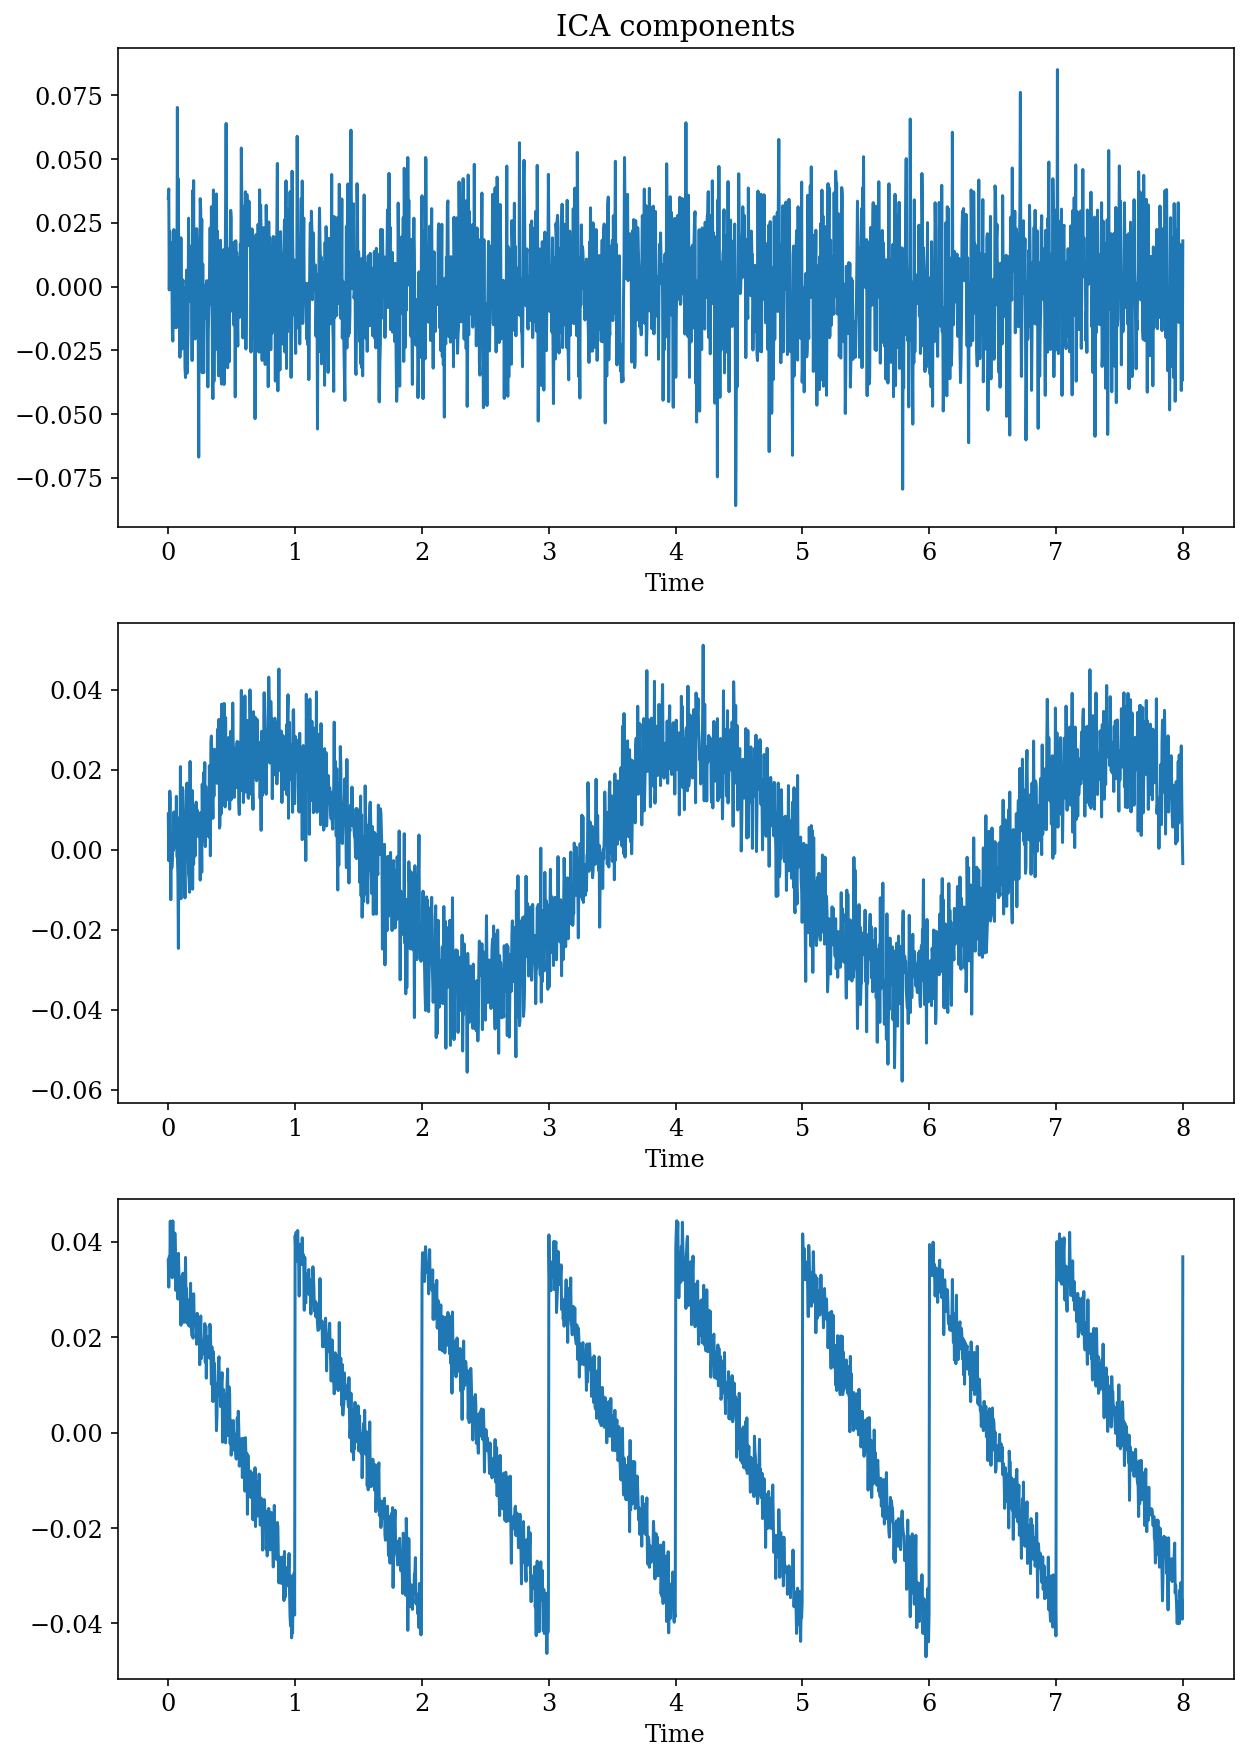

In [7]:
fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs, ica_fit.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('ICA components');

One panel shows a sinusoidal signal: fit it to find the period

### frequentist approach

In [8]:
def sinusoidal(t, A, T, phase):
    return A * np.sin(2*np.pi/T * t + phase)

In [90]:
y = ica_fit[:,1] #sinusoidal data
p0 = [0.01, 3, 0] #initial guesses, looking at the signal
best_p, cov = curve_fit(sinusoidal, time, y, p0 = p0)

In [10]:
best_p

array([0.02832313, 3.31801679, 0.03865713])

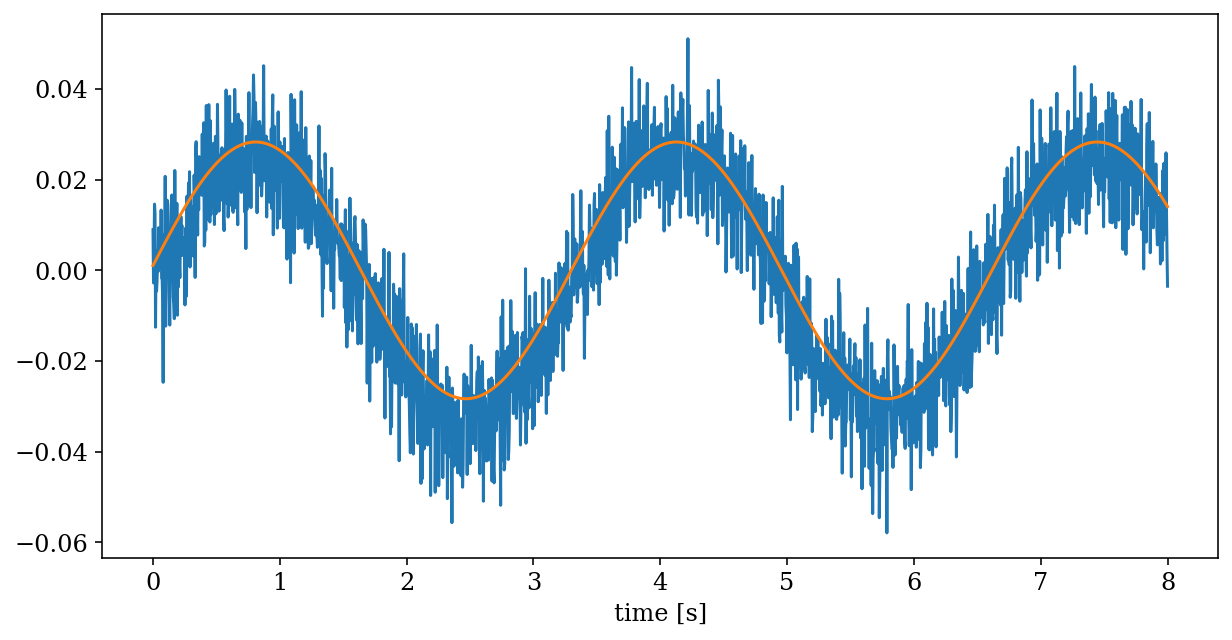

In [11]:
plt.figure(figsize=(10,5))
plt.plot(time, y)
plt.plot(time, sinusoidal(time, *best_p))
plt.xlabel('time [s]')
plt.show()

In [118]:
T_freq, sigma_freq = best_p[1], np.sqrt(cov[1,1])

print('the period of the signal is T = ( %.3f +- %.3f) s' % (T_freq, sigma_freq))

the period of the signal is T = ( 3.318 +- 0.008) s


are the errors gaussian?

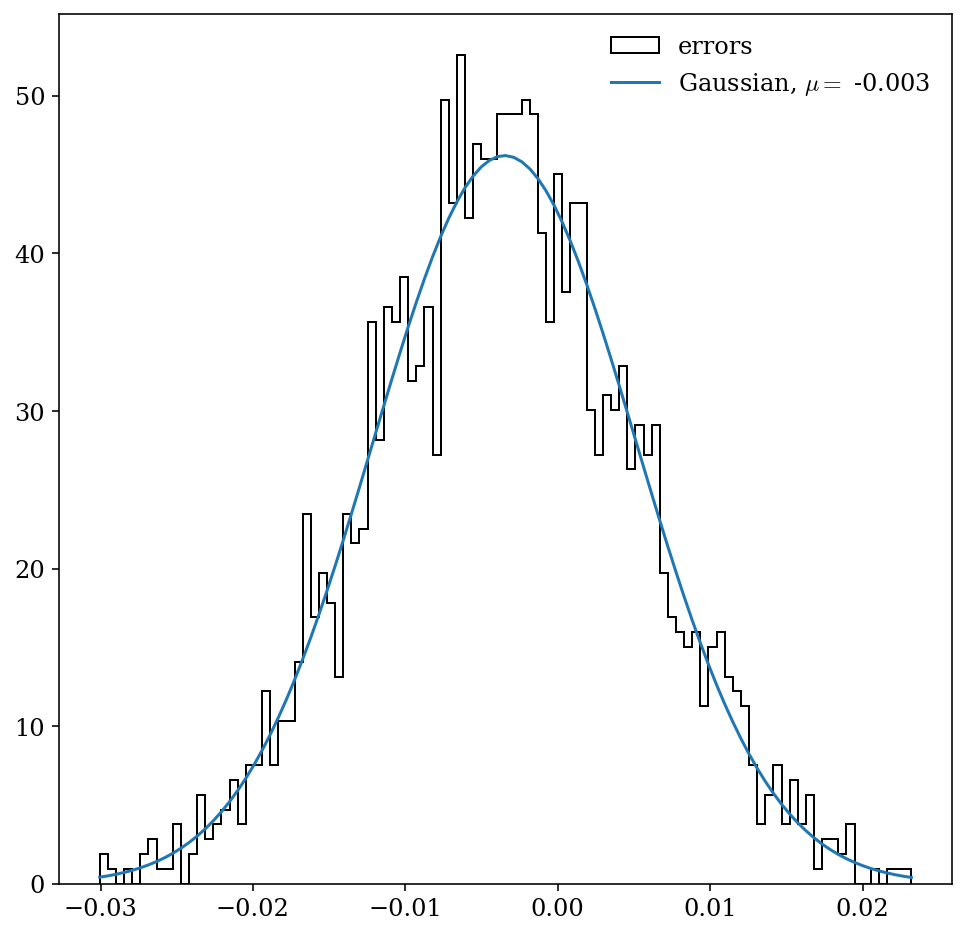

In [51]:
import scipy.stats as stats

histo = np.histogram(y - sinusoidal(time, *best_p), bins = 100)
histo_rv = stats.rv_histogram(histo)

mean, std = histo_rv.mean(), histo_rv.std()
norm = stats.norm(mean, std)
plt.hist(y - sinusoidal(time, *best_p), bins=100, histtype = 'step', color='k', density = True, label = 'errors')
plt.plot(histo[1],norm.pdf(histo[1]), label = r'Gaussian, $\mu=$ %.3f' % mean)

plt.legend(frameon=False)
plt.show()

gaussian centered in ~0 $\implies$ FINE

### Bayesian approach

In [52]:
def sin_model(theta, t):
    A, T, phase = theta
    return A * np.sin(2*np.pi/T * t + phase)

In [53]:
def log_likelihood(theta, t, y, sigma, model = sin_model):
    y_model = model(theta, t)
    return - 0.5 * np.sum((y - y_model)**2 / sigma**2)

In [54]:
def log_prior(theta, limits): #assume uniform priors
    A, T, phase = theta
    A_min, A_max, T_min, T_max, phase_min, phase_max = limits
    if A_min < A < A_max and T_min < T < T_max and phase_min < phase < phase_max:
        return 0.0
    return - np.inf

In [55]:
def log_posterior(theta, limits, t, y, sigma, model = sin_model):
    return log_likelihood(theta, t, y, sigma, model = sin_model) + log_prior(theta, limits)

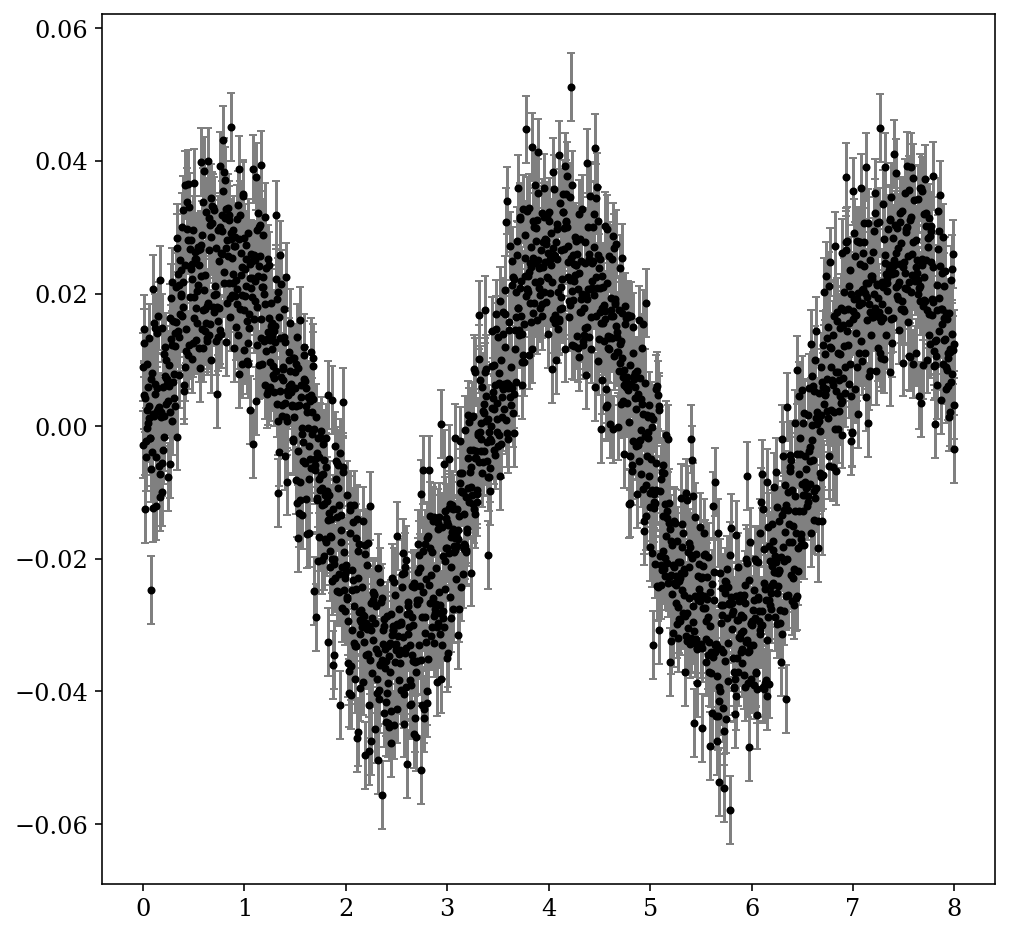

In [109]:
limits = [0.01, 0.06, 2, 4, -np.pi, np.pi]

sigma = max(y) / 10 #the instrumental errors are not provided, assume a constant error of 0.1 * the max

plt.errorbar(time, y, yerr = sigma, fmt ='.k', ecolor = 'gray', capsize = 2)
plt.show()

In [110]:
#emcee 
n_dim = 3
n_walkers = 25
n_steps = int(1e4)

#initial guess
theta_guess = best_p + 1e-4*np.random.rand(n_walkers, n_dim) 

In [111]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=[limits, time, y, sigma, sin_model])
sampler.run_mcmc(theta_guess, n_steps)

print('done')

done


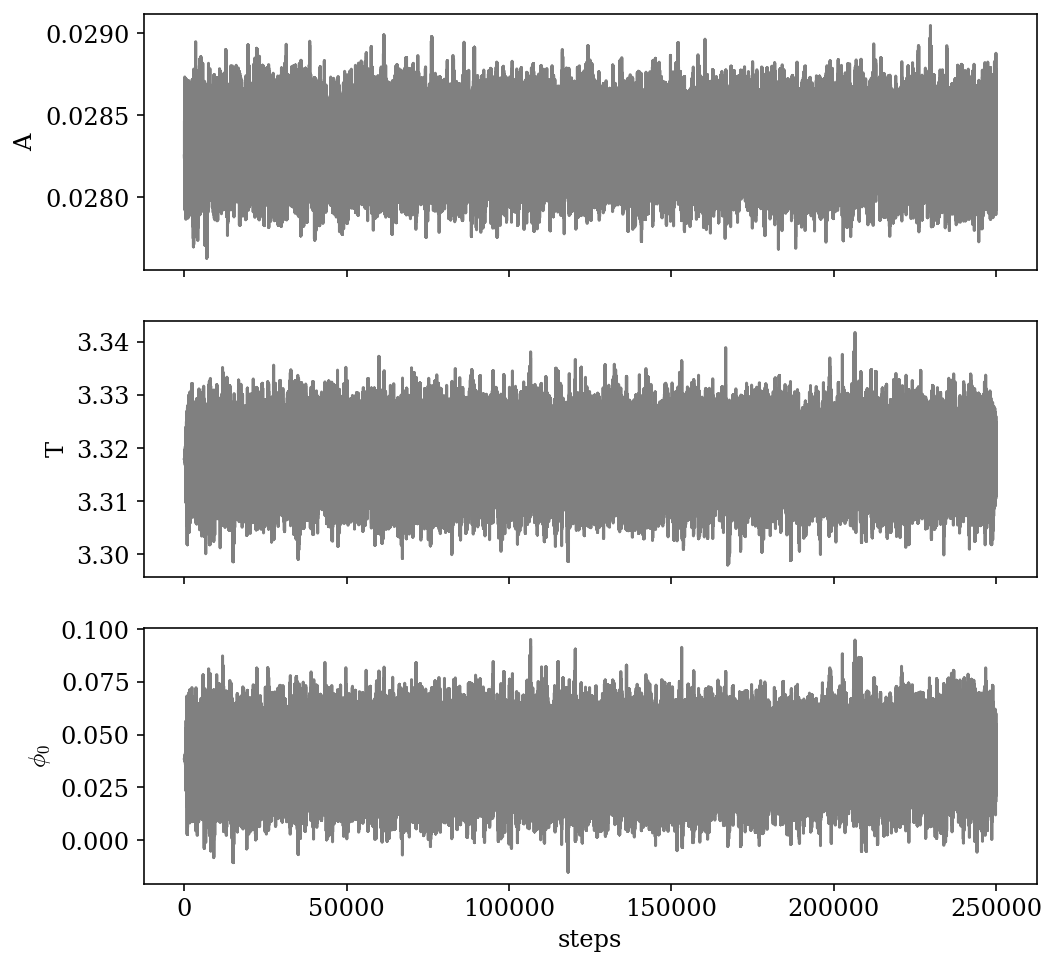

In [112]:
#chains
samples = sampler.get_chain(flat = True)

fig, axes = plt.subplots(n_dim, sharex = True)
label = ['A', 'T', r'$\phi_0$']
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, i], c = 'gray')
    ax.set_ylabel(label[i])
plt.xlabel('steps') 
plt.show()

In [113]:
#burn and thin the chain
corr_time = sampler.get_autocorr_time()
final_samples = sampler.get_chain(thin = int(max(corr_time)), discard = 4 * int(max(corr_time)), flat = True)
final_samples = samples[100000:]

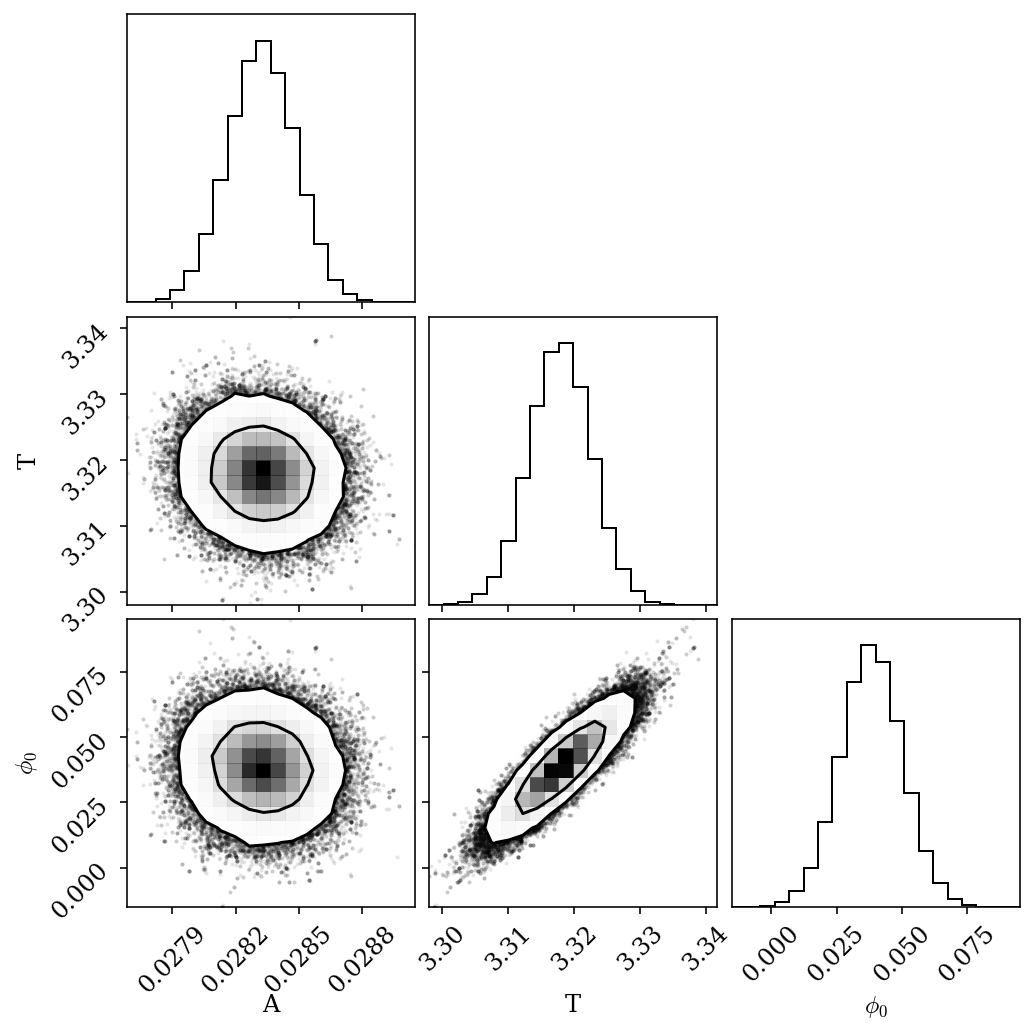

In [114]:
#corner plot
fig = corner.corner(
    final_samples, labels=label, levels=[0.68,0.95]
);

In [117]:
#median and 90% credible region
for i in range(n_dim):
    stats = np.percentile(final_samples[:, i], [50, 5, 95])
    print(label[i] + ' = %.4f + %.4f - %.4f' % (stats[0], stats[2] - stats[0], stats[0] - stats[1]))
    if i == 1:
        T_bayes, sigma_bayes = stats[0], stats[2] - stats[0]

A = 0.0283 + 0.0003 - 0.0003
T = 3.3180 + 0.0078 - 0.0078
$\phi_0$ = 0.0385 + 0.0197 - 0.0196


In [123]:
tau = np.abs(T_bayes - T_freq) / np.sqrt(sigma_bayes**2 + sigma_freq**2)

print('The frequentist and bayesian estimate of T are %.1e sigma apart' % tau)

The frequentist and bayesian estimate of T are 3.0e-03 sigma apart


estimates fully consistent

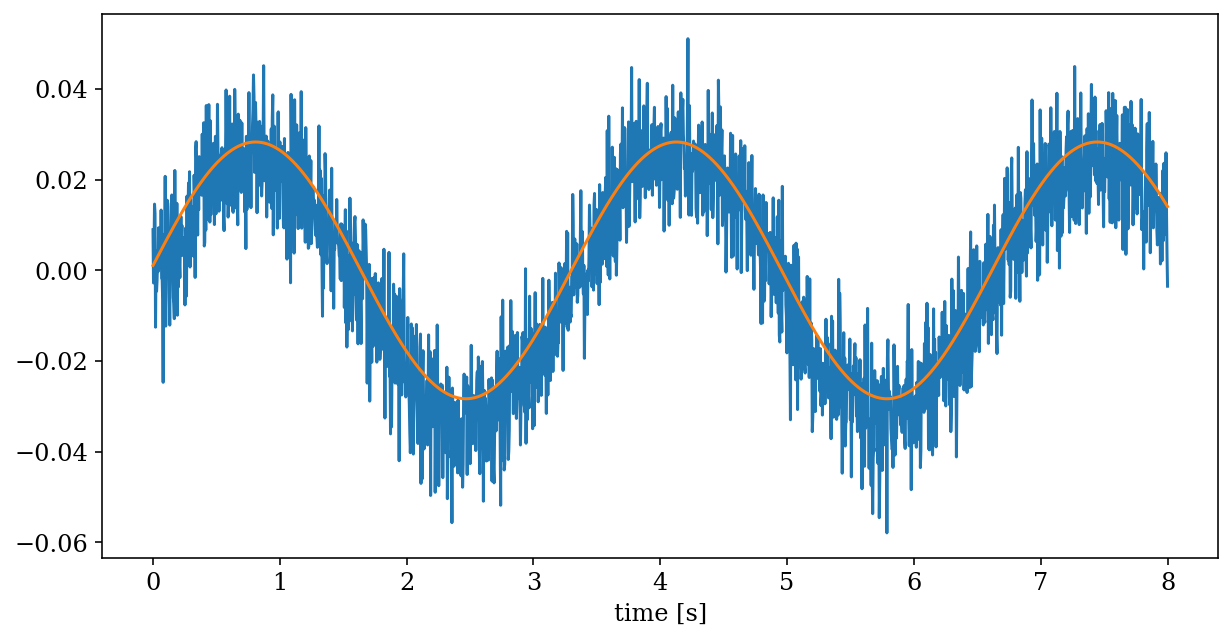

In [116]:
plt.figure(figsize=(10,5))
plt.plot(time, y)
plt.plot(time, sinusoidal(time, *np.percentile(final_samples[:, :], 50, axis=0)))
plt.xlabel('time [s]')
plt.show()